http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

## Setting up the problem

In [2]:
data = np.random.randn(20)

In [3]:
data

array([-1.0856306 ,  0.99734545,  0.2829785 , -1.50629471, -0.57860025,
        1.65143654, -2.42667924, -0.42891263,  1.26593626, -0.8667404 ,
       -0.67888615, -0.09470897,  1.49138963, -0.638902  , -0.44398196,
       -0.43435128,  2.20593008,  2.18678609,  1.0040539 ,  0.3861864 ])

c:\users\scott clay\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


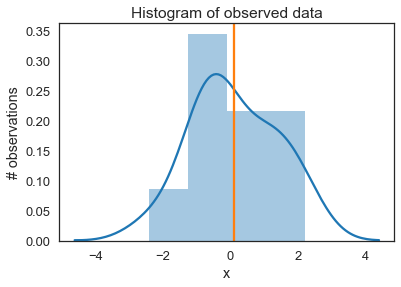

In [33]:
ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax)
ax.plot([data.mean(),data.mean()],[0,2.0], label = 'data')
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations')

c:\users\scott clay\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


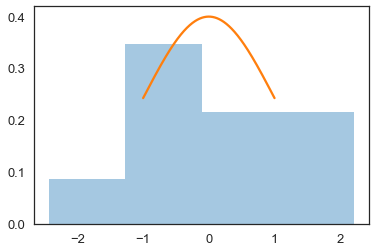

In [44]:
#likelihood_current = norm(mu_current, 1).pdf(data).prod()
#likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
y = norm(loc=0.).pdf(x)
ax2 = plt.subplot()
sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
ax2.plot(x, y)
#ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
#ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')


In [5]:
data.mean()

0.11441773195529023

In [22]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x), mu_post, sigma_post

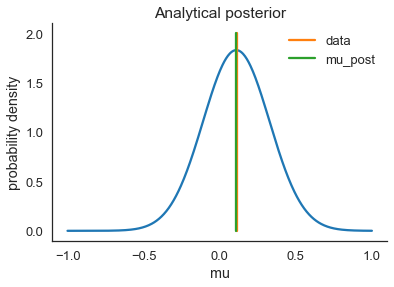

In [23]:
ax = plt.subplot()
x = np.linspace(-1,1,500)
posterior_analytical, mu_post, sigma_post = calc_posterior_analytical(data,x,0.,1.)
ax.plot(x,posterior_analytical)
ax.plot([data.mean(),data.mean()],[0,2.0], label = 'data')
ax.plot([mu_post,mu_post],[0.0,2.0], label = 'mu_post')
ax.set(xlabel='mu', ylabel='probability density', title='Analytical posterior')
ax.legend()
sns.despine()

In [24]:
data.mean(), data.var(), data.std()

(0.11441773195529023, 1.5021278845126171, 1.2256132687404364)

In [25]:
x.mean(), x.var(), x.std()

(-8.526512829121202e-17, 0.33466933867735466, 0.5785061267414154)

In [26]:
mu_post, sigma_post

(0.10896926852884785, 0.047619047619047616)

The posterior mean is calculated from the original data (data) and the new evidence (x) based on their means and variances. The variance is used to determine which is more strongly believed in the calculation of the posterior mean. 

In this case, you can see how the datas variance was quite large, where as the new x wasn't, hence the posterior mean shifted back towards zero from the data mean. 

Note that the posterior mean is a weighted average of the prior mean and the new data mean. The weight on the prior mean is inversely proportional to the variance of the prior mean, and the weight on the new data (x) is inversly prop to the variance of the new data mean. Thus, if the prior mean is very precise relative to the new data mean, then we should weigh it higher. And vice versa. Combining both the prior and new data information gives us a more precise esitmate than if we used either source indepentenly. 

## Explaining MCMC sampling with code

In [17]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [29]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical, _a,_b= calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current, _a,_b = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal,_a,_b = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

c:\users\scott clay\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


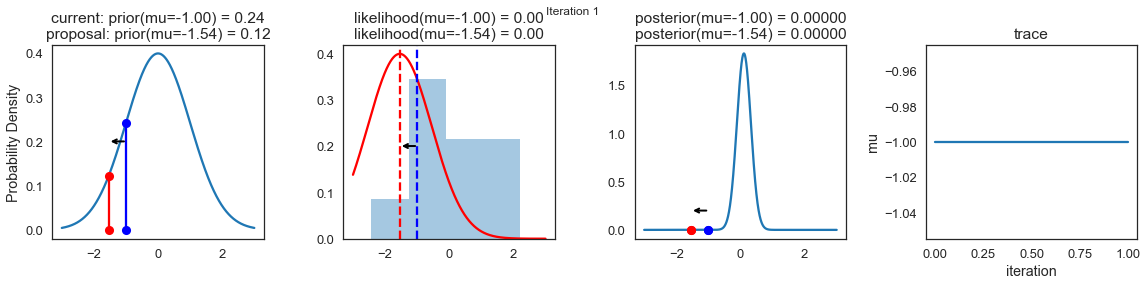

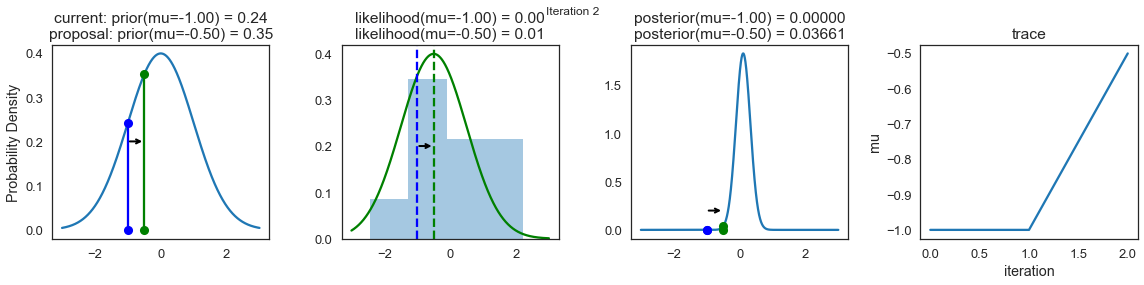

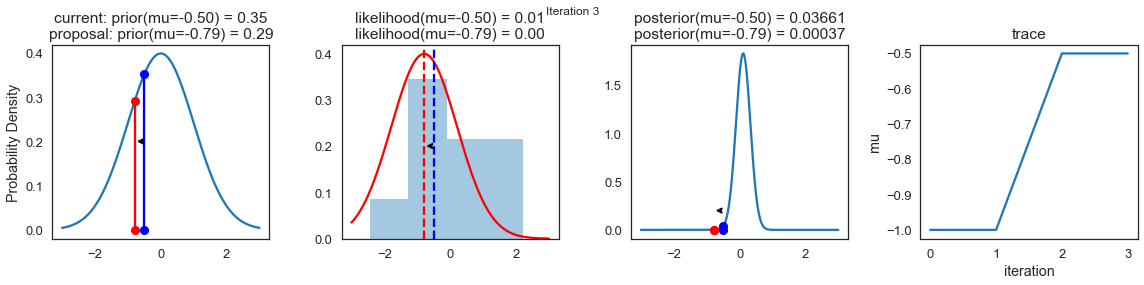

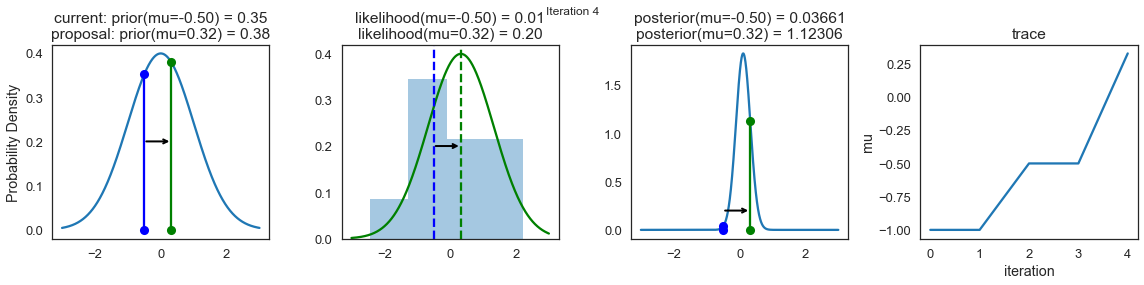

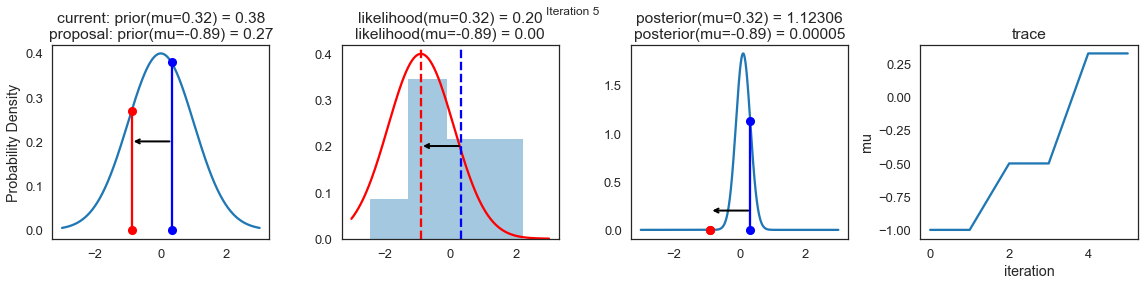

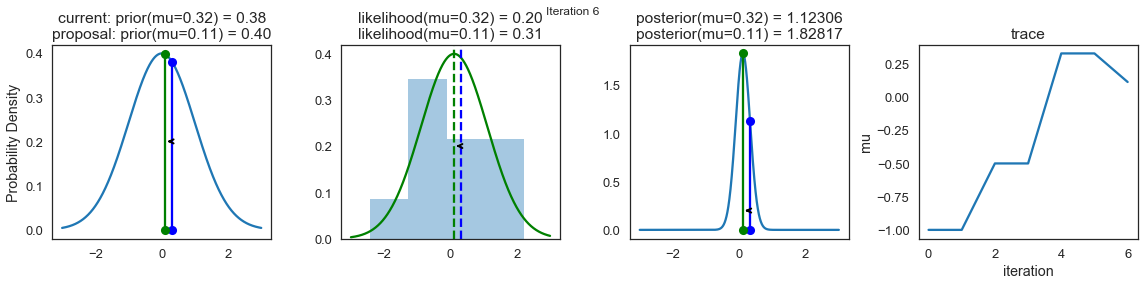

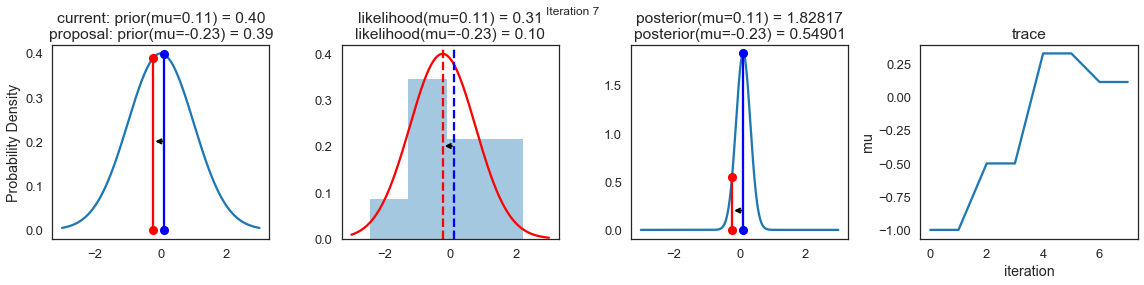

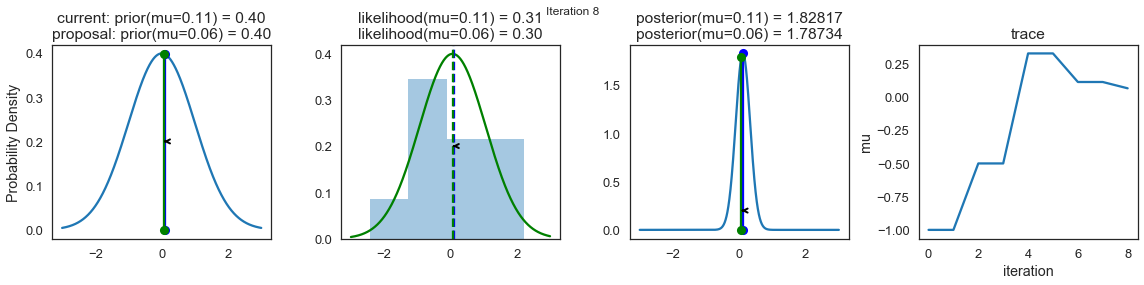

In [30]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);